In [2]:
def in_jupyter():
    try:
        from IPython import get_ipython
        shell = get_ipython().__class__.__name__
        print(f"Running in shell: {shell}")
        return shell == "ZMQInteractiveShell"
    except Exception:
        return False

if in_jupyter():
    from IPython import get_ipython
    ip = get_ipython()
    ip.run_line_magic("load_ext", "autoreload")
    ip.run_line_magic("autoreload", "3")


import matplotlib.pyplot as plt
import numpy as np

plt.style.use("dark_background")

def evaluate_detection_proper(detected_spikes, true_indices, tolerance=50):
    """
    Proper evaluation - each true spike can only be matched once
    """
    detected_spikes = np.array(detected_spikes)
    true_indices = np.array(true_indices)
    
    true_matched = np.zeros(len(true_indices), dtype=bool)
    detected_matched = np.zeros(len(detected_spikes), dtype=bool)
    
    # For each detected spike, find closest true spike
    for i, det_spike in enumerate(detected_spikes):
        distances = np.abs(true_indices - det_spike)
        closest_idx = np.argmin(distances)
        
        # If within tolerance and not already matched
        if distances[closest_idx] <= tolerance and not true_matched[closest_idx]:
            true_matched[closest_idx] = True
            detected_matched[i] = True
    
    true_positives = np.sum(true_matched)
    false_positives = np.sum(~detected_matched)
    false_negatives = np.sum(~true_matched)
    
    precision = true_positives / len(detected_spikes) if len(detected_spikes) > 0 else 0
    recall = true_positives / len(true_indices) if len(true_indices) > 0 else 0
    
    return {
        'TP': true_positives,
        'FP': false_positives,
        'FN': false_negatives,
        'precision': precision,
        'recall': recall,
        'f1': 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    }

Running in shell: ZMQInteractiveShell


In [3]:
# LOAD BASE DATASET

from cwc.src.data import Dataset
from cwc.src.signal import BandpassFilter
from cwc.src.signal import NoisyData
import numpy as np
import matplotlib.pyplot as plt


dataset = Dataset()
dataset.load_from_mat("cwc/data/D1.mat")

print("Loaded Dataset:")
print("\tData shape:", dataset.data.shape)
print("\tIndices shape:", dataset.indices.shape)
print("\tClasses shape:", dataset.classes.shape)
print("\tUnique classes:", np.unique(dataset.classes))
print("\tClass instances:", np.bincount(dataset.classes))
print("\tMin distance between spikes:", np.min(np.diff(np.sort(dataset.indices))))

# SPLIT DATASET INTO TRAINING AND TEST SETS

train_data = dataset
test_data = train_data.split_into_test(test_ratio=0.2)

# print basic info about the training and test sets
print("\nTraining Set:")
print("\tData shape:", train_data.data.shape)
print("\tIndices shape:", train_data.indices.shape)
print("\tClasses shape:", train_data.classes.shape)
print("\tClass instances:", np.bincount(train_data.classes))
print("\nTest Set:")
print("\tData shape:", test_data.data.shape)
print("\tIndices shape:", test_data.indices.shape)
print("\tClasses shape:", test_data.classes.shape)
print("\tClass instances:", np.bincount(test_data.classes))


Loaded Dataset:
	Data shape: (1440000,)
	Indices shape: (2176,)
	Classes shape: (2176,)
	Unique classes: [1 2 3 4 5]
	Class instances: [  0 458 441 406 444 427]
	Min distance between spikes: 1

Training Set:
	Data shape: (1152000,)
	Indices shape: (1763,)
	Classes shape: (1763,)
	Class instances: [  0 354 367 323 371 348]

Test Set:
	Data shape: (288000,)
	Indices shape: (413,)
	Classes shape: (413,)
	Class instances: [  0 104  74  83  73  79]


data shape in wavelet denoise: (1152000,)
data shape in wavelet denoise: (1152000,)
data shape in wavelet denoise: (1152000,)


C:\Users\sebam\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


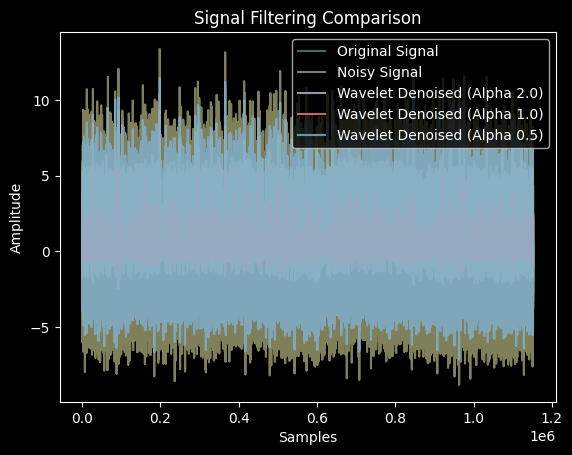

In [4]:
# compare wavelet denoisuing vs bandpass filtering vs no filtering

base_data = train_data.data.copy()

noisy_data = NoisyData(train_data)
noisy_data.noisify(0.2)

wavelet_filter = BandpassFilter(noisy_data)
wavelet_filter.appply_wavelet_denoise(wavelet='db4', level=4, alpha=2.0)

wavelet_filter_2 = BandpassFilter(noisy_data)
wavelet_filter_2.appply_wavelet_denoise(wavelet='db4', level=4, alpha=1.0)

wavelet_filter_3 = BandpassFilter(noisy_data)
wavelet_filter_3.appply_wavelet_denoise(wavelet='db4', level=4, alpha=0.1)


plt.plot(base_data, label='Original Signal', alpha=0.5)
plt.plot(noisy_data.data, label='Noisy Signal', alpha=0.5)
plt.plot(wavelet_filter.filtered_data, label='Wavelet Denoised (Alpha 2.0)', alpha=0.8)
plt.plot(wavelet_filter_2.filtered_data, label='Wavelet Denoised (Alpha 1.0)', alpha=0.8)
plt.plot(wavelet_filter_3.filtered_data, label='Wavelet Denoised (Alpha 0.5)', alpha=0.8)

plt.legend()
plt.title("Signal Filtering Comparison")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

Spike pairs closer than 60 samples: 162
Percentage of spikes affected: 9.2%
Distance: 1 samples, Count: 1
Distance: 2 samples, Count: 4
Distance: 3 samples, Count: 2
Distance: 4 samples, Count: 2
Distance: 5 samples, Count: 5
Distance: 6 samples, Count: 2
Distance: 8 samples, Count: 6
Distance: 9 samples, Count: 2
Distance: 10 samples, Count: 2
Distance: 11 samples, Count: 1
Distance: 12 samples, Count: 5
Distance: 13 samples, Count: 6
Distance: 14 samples, Count: 1
Distance: 15 samples, Count: 2
Distance: 16 samples, Count: 5
Distance: 17 samples, Count: 5
Distance: 18 samples, Count: 3
Distance: 20 samples, Count: 4
Distance: 21 samples, Count: 1
Distance: 22 samples, Count: 2
Distance: 23 samples, Count: 2
Distance: 24 samples, Count: 2
Distance: 25 samples, Count: 3
Distance: 26 samples, Count: 5
Distance: 27 samples, Count: 6
Distance: 28 samples, Count: 4
Distance: 29 samples, Count: 9
Distance: 31 samples, Count: 3
Distance: 32 samples, Count: 1
Distance: 34 samples, Count: 1
Di

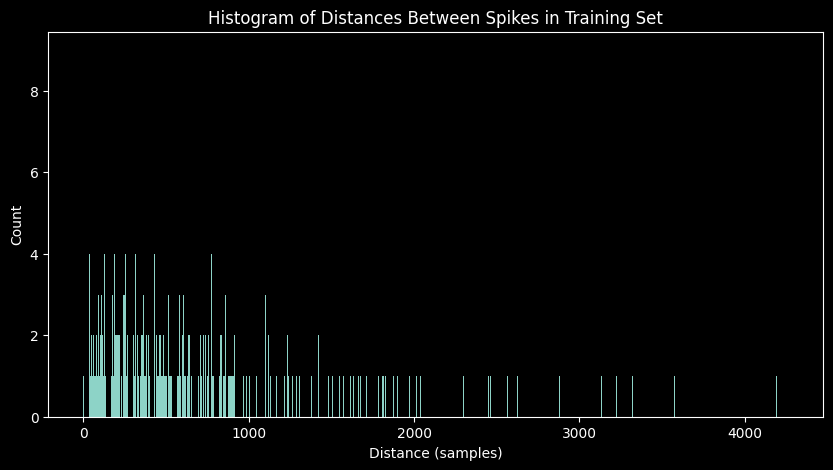

In [5]:
# identify the spacing between spikes in the training set
# sort the indices and calculate the differences between consecutive indices

indices = train_data.indices.copy()
indices.sort()

distances = {}
for i in range(1, len(indices)):
    distance = indices[i] - indices[i - 1]
    
    if distance not in distances:
        distances[distance] = 0
    
    distances[distance] += 1

# sort the distances dictionary by key
distances = dict(sorted(distances.items()))

# How many spikes are within 60 samples of each other?
close_pairs = 0
for i in range(len(indices)-1):
    if indices[i+1] - indices[i] < 60:
        close_pairs += 1

print(f"Spike pairs closer than 60 samples: {close_pairs}")
print(f"Percentage of spikes affected: {100*close_pairs/len(indices):.1f}%")

for distance, count in distances.items():
    print(f"Distance: {distance} samples, Count: {count}")

    

# now plot a histogram of the distances

if in_jupyter():
    plt.figure(figsize=(10, 5))
    plt.bar(distances.keys(), distances.values())
    plt.title("Histogram of Distances Between Spikes in Training Set")
    plt.xlabel("Distance (samples)")
    plt.ylabel("Count")
    plt.show()


Running in shell: ZMQInteractiveShell


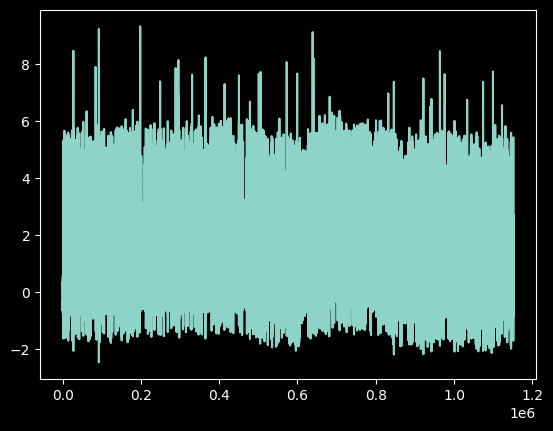

Running in shell: ZMQInteractiveShell


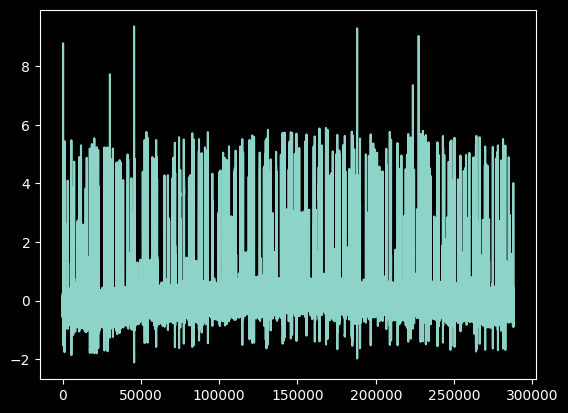

In [6]:

if in_jupyter():
    plt.plot(train_data.data)
    plt.show()

if in_jupyter():
    plt.plot(test_data.data)
    plt.show()


Noisy Dataset (noise level=0.1):
	Data shape: (1152000,)
	Indices shape: (1763,)
	Classes shape: (1763,)
	Class instances: [  0 354 367 323 371 348]
Running in shell: ZMQInteractiveShell


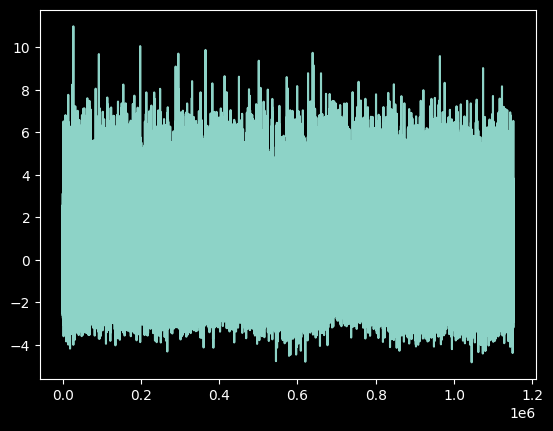


Noisy Dataset (noise level=0.3):
	Data shape: (1152000,)
	Indices shape: (1763,)
	Classes shape: (1763,)
	Class instances: [  0 354 367 323 371 348]
Running in shell: ZMQInteractiveShell


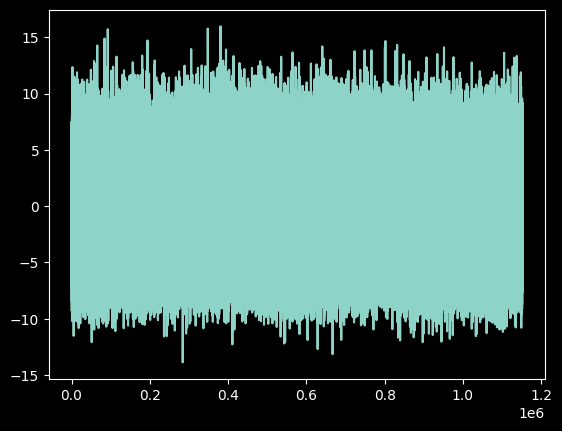


Noisy Dataset (noise level=0.5):
	Data shape: (1152000,)
	Indices shape: (1763,)
	Classes shape: (1763,)
	Class instances: [  0 354 367 323 371 348]
Running in shell: ZMQInteractiveShell


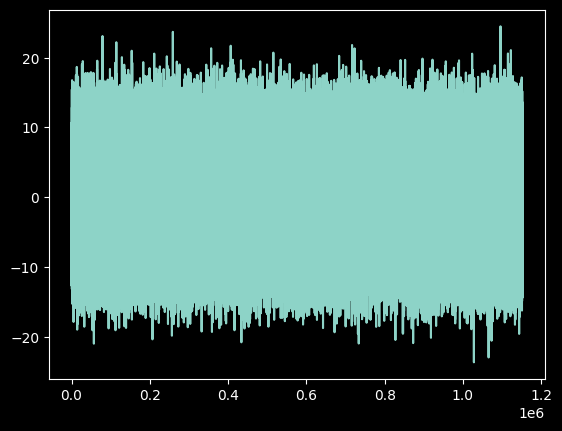

In [7]:
# MAKE NOISIER DATASETS

noise_levels = [0.1, 0.3, 0.5]

noisy_datasets = []

for noise_level in noise_levels:
    noisy_data_maker = NoisyData(train_data)
    noisy_data_maker.noisify(noise_level)
    noisy_datasets.append(noisy_data_maker)
    print(f"\nNoisy Dataset (noise level={noise_level}):")
    print("\tData shape:", noisy_data_maker.data.shape)
    print("\tIndices shape:", noisy_data_maker.indices.shape)
    print("\tClasses shape:", noisy_data_maker.classes.shape)
    print("\tClass instances:", np.bincount(noisy_data_maker.classes))

    if in_jupyter():
        plt.plot(noisy_data_maker.data)
        plt.show()


Running in shell: ZMQInteractiveShell


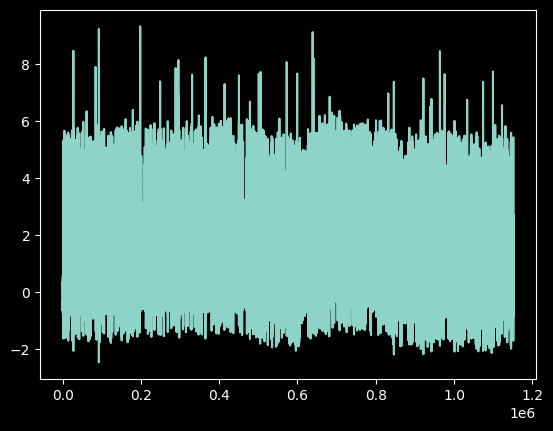

Running in shell: ZMQInteractiveShell


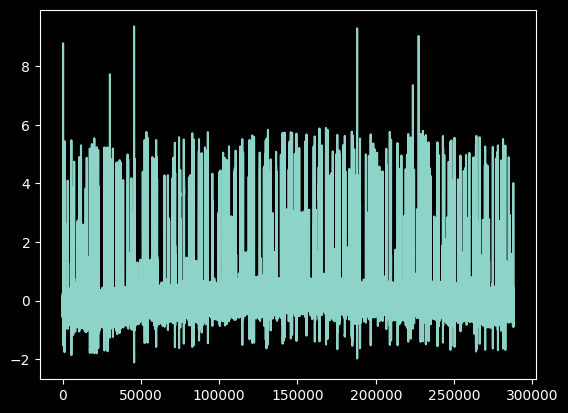

In [8]:
from cwc.src.signal import BandpassFilter
import matplotlib.pyplot as plt

train_filter = BandpassFilter(train_data)
#train_filter.appply_wavelet_denoise(alpha=0.5)

test_filter = BandpassFilter(test_data)
#test_filter.appply_wavelet_denoise(alpha=0.5)

if in_jupyter():
    plt.plot(train_filter.filtered_data)
    plt.show()

if in_jupyter():
    plt.plot(test_filter.filtered_data)
    plt.show()


Training Set Spike Detection:
	Correct Detections: 1668 out of  1763
	Total Detected Spikes: 1730
	False Positives: 62
	False Negatives: 95
	Incorrect Detections: 157
	Recall: 94.61%
	Precision: 96.42%
Running in shell: ZMQInteractiveShell


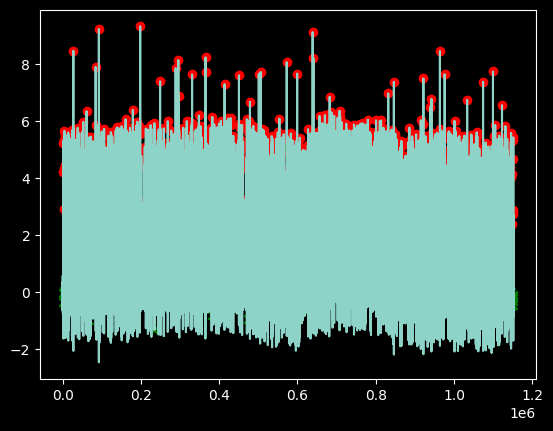

Running in shell: ZMQInteractiveShell


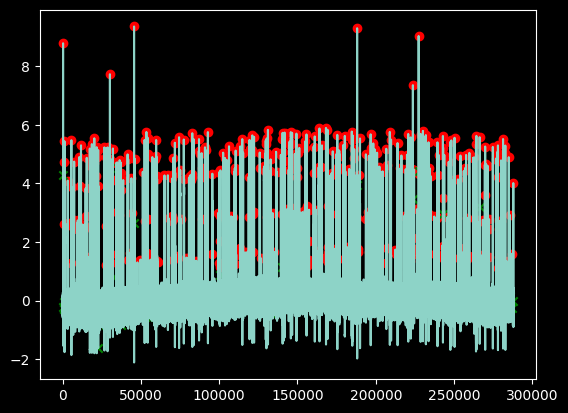

In [9]:
# TEST PURE MAD SPIKE DETECTION

from cwc.src.signal import SpikeDetector

mad_gain = 4.0
min_distance = 25

train_spikes = SpikeDetector(train_filter)
train_mad = train_spikes.calculate_mad()
train_spikes.detect_spikes(mad=train_mad, mad_gain=mad_gain, distance=min_distance)

test_spikes = SpikeDetector(test_filter)
test_mad = test_spikes.calculate_mad()
test_spikes.detect_spikes(mad=test_mad, mad_gain=mad_gain, distance=min_distance)

## evaluate spike detection performance on training set
correct_detections = 0
false_positives = 0
false_negatives = 0

for detected_spike in train_spikes.detected_spikes:
    if any(np.abs(train_spikes.indices - detected_spike) <= min_distance):
        correct_detections += 1
    else:
        false_positives += 1

incorrect_detections = false_positives + (len(train_spikes.indices) - correct_detections)

print("Training Set Spike Detection:")
print("\tCorrect Detections:", correct_detections, "out of ", len(train_spikes.indices))
print("\tTotal Detected Spikes:", len(train_spikes.detected_spikes))
print("\tFalse Positives:", false_positives)
print("\tFalse Negatives:", len(train_spikes.indices) - correct_detections)
print("\tIncorrect Detections:", incorrect_detections)
print("\tRecall: {:.2f}%".format(100 * correct_detections / len(train_spikes.indices)))
print("\tPrecision: {:.2f}%".format(100 * correct_detections / (correct_detections + false_positives)))

# plot detected spikes on training data, alonside the true spike indices

if in_jupyter():
    plt.plot(train_filter.filtered_data)
    plt.scatter(train_spikes.detected_spikes, train_filter.filtered_data[train_spikes.detected_spikes], color='red')
    plt.scatter(train_spikes.indices, train_filter.filtered_data[train_spikes.indices], color='green', marker='x')
    plt.show()

if in_jupyter():
    plt.plot(test_filter.filtered_data)
    plt.scatter(test_spikes.detected_spikes, test_filter.filtered_data[test_spikes.detected_spikes], color='red')
    plt.scatter(test_spikes.indices, test_filter.filtered_data[test_spikes.indices], color='green', marker='x')
    plt.show()


In [10]:
# After spike detection
from cwc.src.data import SignalProcessor

processor = SignalProcessor(train_data)
processor.filtered_data = train_filter.filtered_data

# Align and extract spikes
processor.detected_spikes = train_spikes.detected_spikes
processor.align_spikes(target_peak_pos=20, window_size=64)

# Extract PCA features
processor.extract_features()

# Match to ground truth for training
processor.correlate_classes(distance_threshold=50)

# Train classifier
classifier = processor.create_classifier()

print(f"Classifier trained with {len(processor.correlated_classes)} samples")
print(f"Training accuracy: {classifier.accuracy:.2%}")

Classifier trained with 1729 samples
Training accuracy: 100.00%


In [11]:
# Create new processor for test data
test_processor = SignalProcessor(test_data)
test_processor.filtered_data = test_filter.filtered_data
test_processor.detected_spikes = test_spikes.detected_spikes
test_processor.align_spikes(target_peak_pos=20, window_size=64)
test_processor.scaler = processor.scaler  # Use the same scaler as training
test_processor.pca = processor.pca  # Use the same PCA as training
test_processor.extract_features()

# Classify
predictions = classifier.classifier.predict(test_processor.features)

# Evaluate test set performance
correct_predictions = 0

for i, detected_index in enumerate(test_processor.aligned_indices):
    predicted_class = predictions[i]
    
    # Find closest ground truth spike
    distances = np.abs(test_data.indices - detected_index)
    closest_idx = np.argmin(distances)
    
    # Only count if detection is close enough to a real spike
    if distances[closest_idx] <= 50:
        true_class = test_data.classes[closest_idx]
        if predicted_class == true_class:
            correct_predictions += 1

total_predictions = len(predictions)
print("Test Set Classification:")
print("\tCorrect Predictions:", correct_predictions, "out of ", total_predictions)
print("\tAccuracy: {:.2f}%".format(100 * correct_predictions / total_predictions if total_predictions > 0 else 0))

Test Set Classification:
	Correct Predictions: 418 out of  431
	Accuracy: 96.98%


====STARTING NOISY DATA TESTS====
Running in shell: ZMQInteractiveShell


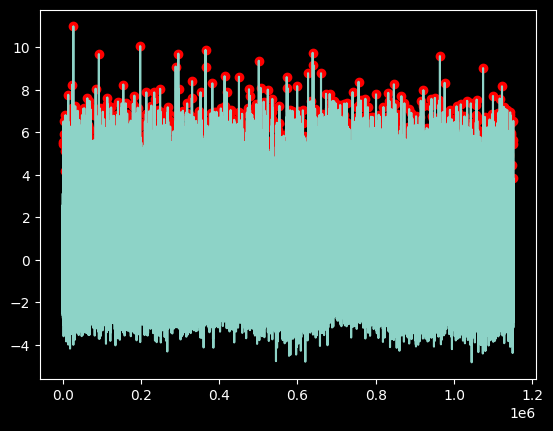

Single Pass Spike Detection (0.1):
P=0.924, R=0.750, F1=0.828
Running in shell: ZMQInteractiveShell


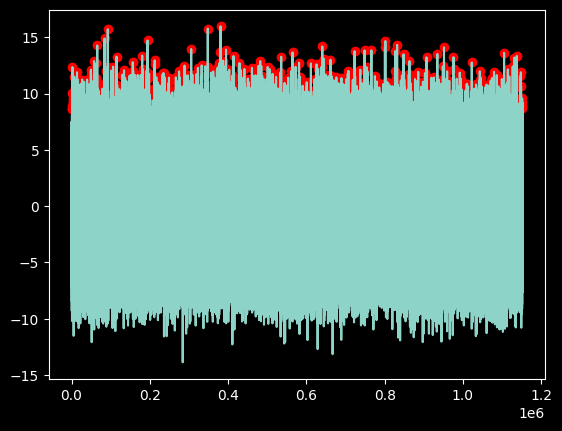

Single Pass Spike Detection (0.3):
P=0.450, R=0.495, F1=0.472
Running in shell: ZMQInteractiveShell


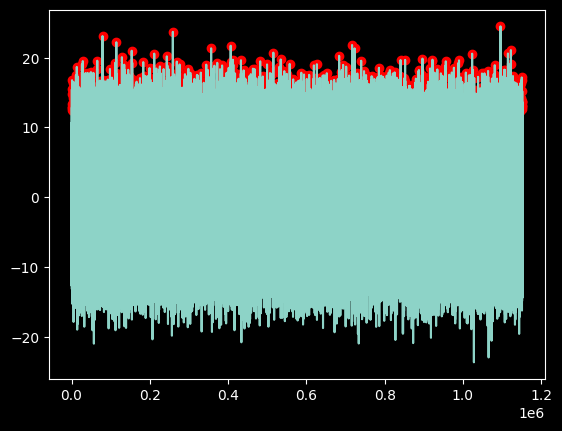

Single Pass Spike Detection (0.5):
P=0.223, R=0.559, F1=0.318


In [12]:
# test on noisy data

min_distance = 60

mad_gains = [3.6, 3.0, 2.6]

print("====STARTING NOISY DATA TESTS====")
for i, noisy_dataset in enumerate(noisy_datasets):
    
    unlabelled_filter = BandpassFilter(noisy_dataset)
    #unlabelled_filter.appply_wavelet_denoise()
    
    unlabelled_spikes = SpikeDetector(unlabelled_filter)
    unlabelled_mad = unlabelled_spikes.calculate_mad()
    unlabelled_spikes.detect_spikes(mad=unlabelled_mad, mad_gain=mad_gains[i], distance=min_distance)

    if in_jupyter():
        plt.plot(unlabelled_filter.filtered_data)
        plt.scatter(unlabelled_spikes.detected_spikes, unlabelled_filter.filtered_data[unlabelled_spikes.detected_spikes], color='red')
        plt.show()
    
    metrics = evaluate_detection_proper(unlabelled_spikes.detected_spikes, 
                                       unlabelled_spikes.indices, 
                                       tolerance=50)
    
    print(f"Single Pass Spike Detection ({noise_levels[i]}):")    
    print(f"P={metrics['precision']:.3f}, R={metrics['recall']:.3f}, F1={metrics['f1']:.3f}")


In [13]:
# SYSTEMATIC THRESHOLD SWEEP
print("====THRESHOLD SWEEP====")

test_gains = np.arange(1.6, 5.0, 0.1)

for noise_idx, noisy_dataset in enumerate(noisy_datasets):
    print(f"\n=== Noise Level {noise_levels[noise_idx]} ===")
    
    unlabelled_filter = BandpassFilter(noisy_dataset)
    #unlabelled_filter.appply_wavelet_denoise(alpha=0.0)
    
    best_f1 = 0
    best_gain = 0
    results = []
    
    for gain in test_gains:
        detector = SpikeDetector(unlabelled_filter)
        mad = detector.calculate_mad()
        detector.detect_spikes(mad=mad, mad_gain=gain, distance=60)
        
        metrics = evaluate_detection_proper(detector.detected_spikes, 
                                           noisy_dataset.indices, 
                                           tolerance=50)
        
        results.append({
            'gain': gain,
            'p': metrics['precision'],
            'r': metrics['recall'],
            'f1': metrics['f1']
        })
        
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_gain = gain
    
    # Print all results
    for r in results:
        marker = " <-- BEST" if r['gain'] == best_gain else ""
        print(f"  Gain {r['gain']:.1f}: P={r['p']:.3f}, R={r['r']:.3f}, F1={r['f1']:.3f}{marker}")
    
    print(f"Best: gain={best_gain:.1f}, F1={best_f1:.3f}")

====THRESHOLD SWEEP====

=== Noise Level 0.1 ===
  Gain 1.6: P=0.138, R=0.944, F1=0.241
  Gain 1.7: P=0.145, R=0.943, F1=0.251
  Gain 1.8: P=0.153, R=0.940, F1=0.263
  Gain 1.9: P=0.163, R=0.935, F1=0.278
  Gain 2.0: P=0.176, R=0.930, F1=0.297
  Gain 2.1: P=0.195, R=0.925, F1=0.321
  Gain 2.2: P=0.217, R=0.915, F1=0.351
  Gain 2.3: P=0.248, R=0.908, F1=0.389
  Gain 2.4: P=0.284, R=0.894, F1=0.431
  Gain 2.5: P=0.326, R=0.884, F1=0.477
  Gain 2.6: P=0.380, R=0.869, F1=0.528
  Gain 2.7: P=0.437, R=0.859, F1=0.579
  Gain 2.8: P=0.503, R=0.843, F1=0.630
  Gain 2.9: P=0.574, R=0.829, F1=0.679
  Gain 3.0: P=0.644, R=0.815, F1=0.719
  Gain 3.1: P=0.711, R=0.807, F1=0.756
  Gain 3.2: P=0.772, R=0.796, F1=0.784
  Gain 3.3: P=0.830, R=0.784, F1=0.807
  Gain 3.4: P=0.869, R=0.774, F1=0.819
  Gain 3.5: P=0.901, R=0.760, F1=0.825
  Gain 3.6: P=0.924, R=0.750, F1=0.828
  Gain 3.7: P=0.950, R=0.739, F1=0.831 <-- BEST
  Gain 3.8: P=0.964, R=0.724, F1=0.827
  Gain 3.9: P=0.977, R=0.711, F1=0.823
  Gain

Running in shell: ZMQInteractiveShell


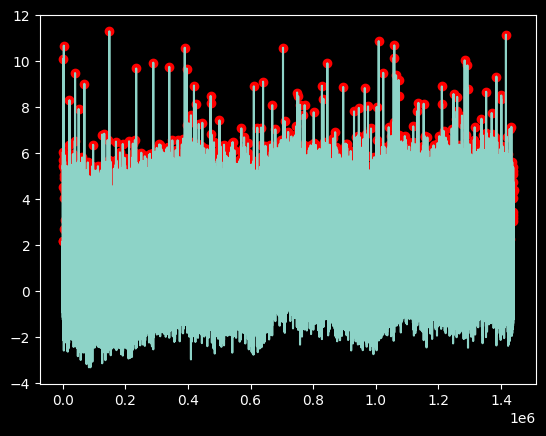

Predictions saved to cwc/data/D2.mat
Predictions for cwc/data/D2.mat: [  0 701 751 247 729 800]
Total spikes detected: 3228
Running in shell: ZMQInteractiveShell


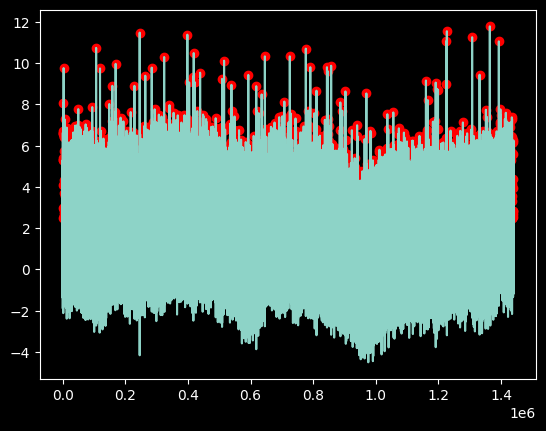

Predictions saved to cwc/data/D3.mat
Predictions for cwc/data/D3.mat: [  0 591 686 326 985 590]
Total spikes detected: 3178
Running in shell: ZMQInteractiveShell


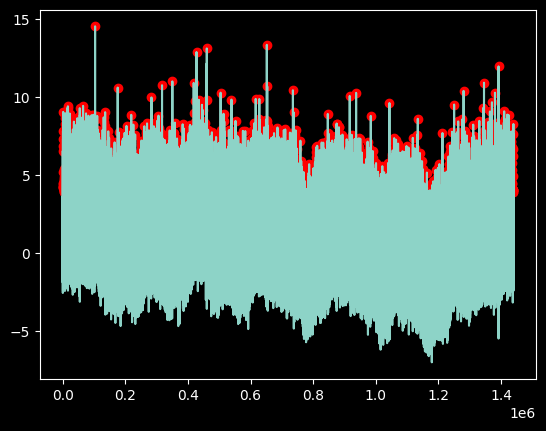

Predictions saved to cwc/data/D4.mat
Predictions for cwc/data/D4.mat: [   0  714  481  182 1212  657]
Total spikes detected: 3246
Running in shell: ZMQInteractiveShell


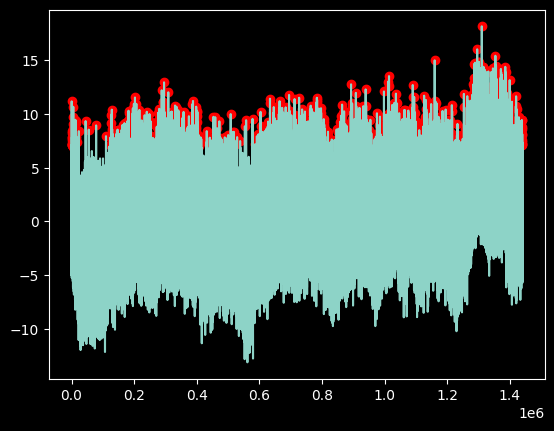

Predictions saved to cwc/data/D5.mat
Predictions for cwc/data/D5.mat: [   0 1030  297  132  649 1141]
Total spikes detected: 3249
Running in shell: ZMQInteractiveShell


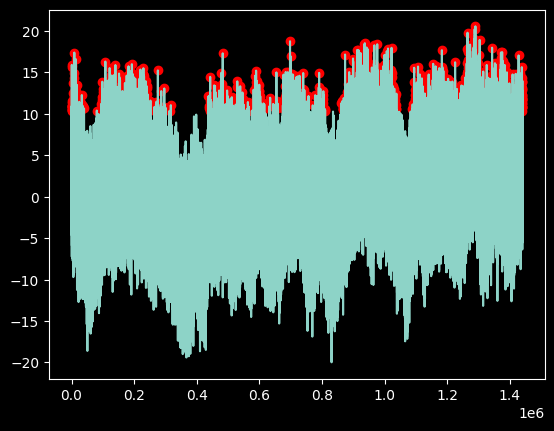

Predictions saved to cwc/data/D6.mat
Predictions for cwc/data/D6.mat: [   0 1113  203   27  460 1616]
Total spikes detected: 3419


In [25]:
# Now apply to the other datasets
unlabelled_datasets = ["cwc/data/D2.mat", "cwc/data/D3.mat", "cwc/data/D4.mat", "cwc/data/D5.mat", "cwc/data/D6.mat"]
mad_gains = [3.1, 2.7, 2.6, 2.5, 2.4]
min_distance = 60

i = 0
for dataset_path in unlabelled_datasets:

    mad_gain = mad_gains[i]
    i += 1

    unlabelled_data = Dataset()
    unlabelled_data.load_from_mat_unlabelled(dataset_path)
    
    unlabelled_filter = BandpassFilter(unlabelled_data)
    #unlabelled_filter.apply_band_pass_filter(filter_low=300, filter_high=3000, sample_rate=25000, order=4)
    
    unlabelled_spikes = SpikeDetector(unlabelled_filter)
    unlabelled_mad = unlabelled_spikes.calculate_mad()
    unlabelled_spikes.detect_spikes(mad=unlabelled_mad, mad_gain=mad_gain, distance=min_distance)

    if in_jupyter():
        plt.plot(unlabelled_filter.filtered_data)
        plt.scatter(unlabelled_spikes.detected_spikes, unlabelled_filter.filtered_data[unlabelled_spikes.detected_spikes], color='red')
        plt.show()
    
    unlabelled_processor = SignalProcessor(unlabelled_data)
    unlabelled_processor.filtered_data = unlabelled_filter.filtered_data
    unlabelled_processor.detected_spikes = unlabelled_spikes.detected_spikes
    unlabelled_processor.align_spikes(target_peak_pos=20, window_size=64)

    unlabelled_processor.scaler = processor.scaler  # Use the same scaler as training
    unlabelled_processor.pca = processor.pca  # Use the same PCA as training
    unlabelled_processor.extract_features()
    
    unlabelled_predictions = classifier.classifier.predict(unlabelled_processor.features)


    unlabelled_data.write_to_mat(dataset_path.replace('cwc/data/', 'cwc/data/output/'), unlabelled_processor.aligned_indices, unlabelled_predictions)
    print(f"Predictions saved to {dataset_path.replace('cwc/data/;', 'cwc/data/output/')}")
    print(f"Predictions for {dataset_path}: {np.bincount(unlabelled_predictions)}")
    print(f"Total spikes detected: {len(unlabelled_processor.aligned_indices)}")

    
    


In [15]:
# Add this after your loop to verify
import scipy.io as spio
test_file = spio.loadmat('cwc/data/output/D6.mat')
print(f"D2 Index length: {len(test_file['Index'][0])}")
print(f"D2 Class length: {len(test_file['Class'][0])}")
print(f"Match: {len(test_file['Index']) == len(test_file['Class'])}")

D2 Index length: 8886
D2 Class length: 8886
Match: True
